In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import least_squares

In [2]:
# from liquidity.response_functions.fitting import scale_function
from util.goodness_of_fit import compute_goodness_of_fit

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
"""
PART 1: determine alpha and beta

For each N in 1..1000
    fit sigmoid and save alpha and beta
Plot scatter of alpha and beta across N
Find optimal
    - define value search range
    - define search step
    - define combinations of alpha/beta to try
    - fit F(x) for all N with each pair of alpha/beta and record goodness of fit results
    - find alpa/beta pair that give the best fit across F(x) for all N


PART 2: find RN and QN by fitting

For each N in 1..1000
    fit the scaling form with fixed F(X) to determine QN and RN scaling factors


PART 3: find scaling of RN and QN
    find the scaling of RN and QN by passing the series to powerlaw-function module
"""

'\nPART 1: determine alpha and beta\n\nFor each N in 1..1000\n    fit sigmoid and save alpha and beta\nPlot scatter of alpha and beta across N\nFind optimal\n    - define value search range\n    - define search step\n    - define combinations of alpha/beta to try\n    - fit F(x) for all N with each pair of alpha/beta and record goodness of fit results\n    - find alpa/beta pair that give the best fit across F(x) for all N\n\n\nPART 2: find RN and QN by fitting\n\nFor each N in 1..1000\n    fit the scaling form with fixed F(X) to determine QN and RN scaling factors\n\n\nPART 3: find scaling of RN and QN\n    find the scaling of RN and QN by passing the series to powerlaw-function module\n'

In [5]:
MAX_LAG = 1001

## PART 1: Define the shape of $F(X)$

In [6]:
tsla_agg_features = pickle.load(open('../../data/generated/tsla_aggregate_features_mo.pkl', 'rb'))

### 1.1 Fit sigmoid for each N

In [7]:
def scale_function(x: float, alpha: float, beta: float) -> float:
    """
    Define the sigmoidal function F(x) as mentioned in the paper.

    Parameters:
    - x (float): The value for which we are calculating the function.
    - alpha (float): Represents the small x growth power.
    - beta (float): Represents the large x growth power.

    Returns:
    - float: The result of the scale function for given x, alpha, and beta.
    """
    return x / (1 + abs(x) ** alpha) ** (beta / alpha)

In [8]:
"""
Alternative options of fitting F(X)

- using curve fit
    from scipy.optimize import curve_fit
    from liquidity.response_functions.fitting import scale_function

    popt, pcov = curve_fit(scale_function, result['vol_imbalance'].values,
                           result['R'].values,
                           bounds=(0, np.inf))
    popt

- using curve fit on binned data

    result = tsla_agg_features[1000][['vol_imbalance', 'R']]

    binned_result = bin_data_into_quantiles(result)
    param = fit_scale_function(binned_result)
    param[0]
"""

def fit_sigmoid_ls(x, y):
    def _residuals(params, x, y):
        return y - scale_function(x, *params)

    num_params = scale_function.__code__.co_argcount - 1
    lower_bounds = [0] * num_params
    upper_bounds = [np.inf] * num_params
    bounds = (lower_bounds, upper_bounds)
    initial_guess = [0.5] * num_params
    result = least_squares(_residuals, initial_guess, args=(x, y),  bounds=bounds)
    return result.x

In [52]:
from liquidity.response_functions.fitting import bin_data_into_quantiles

sigmoid_params = {}
for lag in range(1, MAX_LAG):
    # x = tsla_agg_features[lag]['vol_imbalance'].values
    # y = tsla_agg_features[lag]['R'].values

    result = tsla_agg_features[lag][['vol_imbalance', 'R']]
    binned_result = bin_data_into_quantiles(result)
    x = binned_result['vol_imbalance'].values
    y = binned_result['R'].values
    try:
        param = fit_sigmoid_ls(x, y)
        residuals = y - scale_function(x, *param)
        r2, bic = compute_goodness_of_fit(residuals, y, param)
        sigmoid_params[lag] = param, r2, bic
    except:
        print(f"Something went wrong for lag {lag}")

/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/fitting.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_bin'] = binned_x
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/fitting.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_bin'] = binned_x
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/fitting.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of

### 1.2 Plot distribution of $R_N$ and $Q_N$

In [53]:
sigmoid_params[100]

(array([0.20005024, 0.83819458]), 0.8187104814552485, -133.46060315031016)

In [54]:
alphas = [param[0] for param, r2, bic in sigmoid_params.values()]

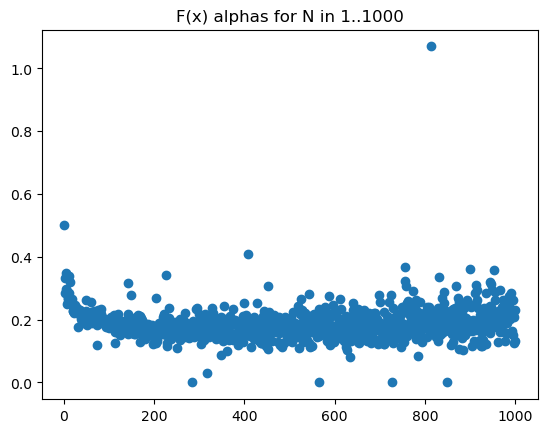

In [55]:
plt.scatter(list(range(1, len(alphas)+1)), alphas)
plt.title("F(x) alphas for N in 1..1000")
plt.show()

In [56]:
betas = [param[1] for param, r2, bic in sigmoid_params.values()]

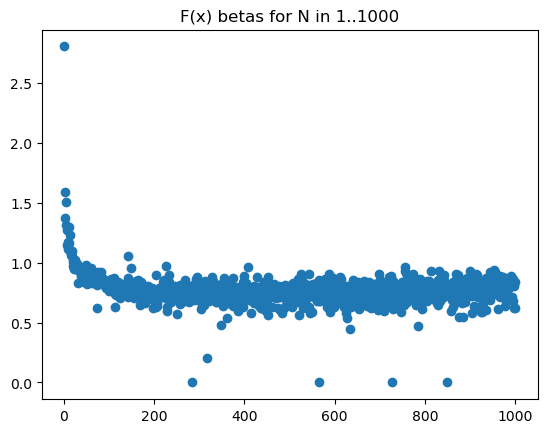

In [57]:
plt.scatter(list(range(1, len(betas)+1)), betas)
plt.title("F(x) betas for N in 1..1000")
plt.show()

### 1.2.2 Overlay with goodness of fit

In [58]:
bics = [bic for param, r2, bic in sigmoid_params.values()]
bics

[-524.4036530426049,
 -477.5955862368214,
 -428.2967410536834,
 -421.67620632388804,
 -408.21166671773847,
 -338.85965458972703,
 -344.70149391801556,
 -374.44932105782215,
 -370.6072247279683,
 -339.7122467635682,
 -213.6189930834664,
 -305.2704115518062,
 -241.91830205772072,
 -499.72774274841555,
 -194.80389311663183,
 -473.7385708633402,
 -508.64175824403327,
 -227.47577603917347,
 -462.0999104690208,
 -203.6171015874241,
 -205.3398466225216,
 -162.66625308486965,
 -430.81717530203423,
 -168.3228383009241,
 -437.4178720544659,
 -407.09995203279453,
 -420.0161547441127,
 -398.3803780734054,
 -115.36331441081859,
 -55.66269480116972,
 -129.16852554026795,
 -353.6771775899952,
 -381.1890395567752,
 -359.6853363917135,
 -363.1376093728305,
 -348.119782065368,
 -59.86809528037915,
 -337.0706463093838,
 -74.55148878081096,
 -64.76866672387914,
 -308.05808025229044,
 -308.53332481207315,
 -308.02242518010576,
 -27.857594002646874,
 -334.57629815463787,
 -293.984807388994,
 -301.8904050189

In [59]:
r2s = [r2 for param, r2, bic in sigmoid_params.values()]

In [60]:
r2s

[0.6188892965706347,
 0.715751286168554,
 0.6521243586836565,
 0.7776761623930272,
 0.765833902014396,
 0.6433330409596161,
 0.7000872308311077,
 0.8081218341831258,
 0.8014256614635275,
 0.7665766515011475,
 0.5751632007294301,
 0.772060916821784,
 0.6921174170295528,
 0.9617781743568155,
 0.5478181444713262,
 0.954957240345566,
 0.9708957256263453,
 0.6671825995018454,
 0.9577346490023833,
 0.6582541245692797,
 0.6061449266976924,
 0.5784243699942364,
 0.9515989236414006,
 0.6088152807094049,
 0.9585392937154051,
 0.9460669297193126,
 0.955388003234592,
 0.9476968881763586,
 0.5034449595727677,
 0.35992545196493153,
 0.5240163208416093,
 0.9271012747382694,
 0.9462490115292403,
 0.9368334012325903,
 0.9398096309419802,
 0.9298251373210982,
 0.4272409365171238,
 0.9288870793925447,
 0.496323633024885,
 0.4715139328981721,
 0.9126773318490031,
 0.9141914428088036,
 0.9162882974614555,
 0.41200994609139363,
 0.9379385925043056,
 0.9053744329847642,
 0.9152826981222384,
 0.91394421503840

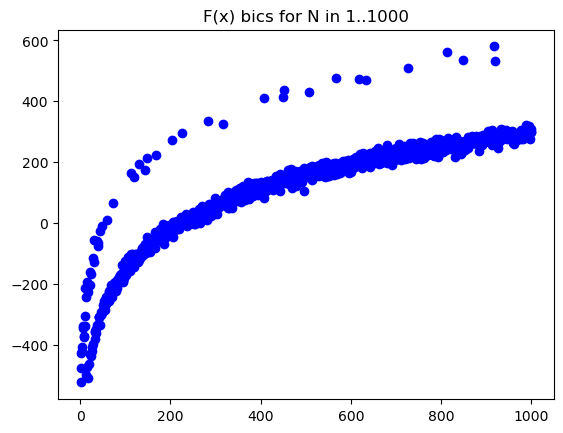

In [61]:
plt.scatter(list(range(1, len(bics)+1)), bics, color='blue')
plt.title("F(x) bics for N in 1..1000")
plt.show()

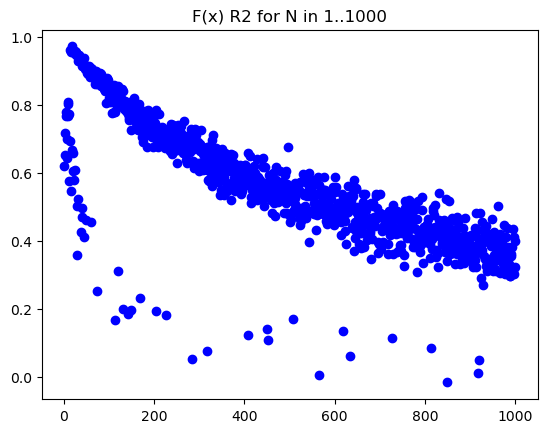

In [62]:
plt.scatter(list(range(1, len(r2s)+1)), r2s, color='blue')
plt.title("F(x) R2 for N in 1..1000")
plt.show()

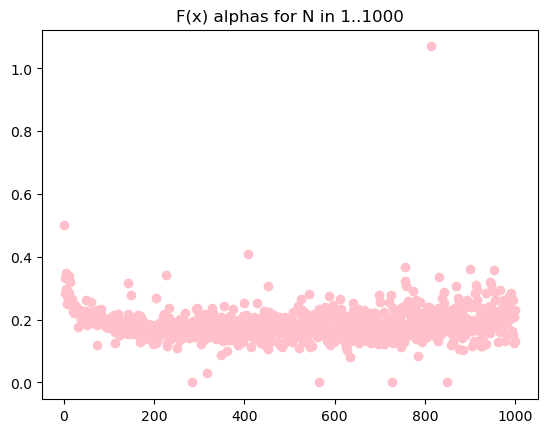

In [63]:
plt.scatter(list(range(1, len(alphas)+1)), alphas, color='pink')
plt.title("F(x) alphas for N in 1..1000")
plt.show()

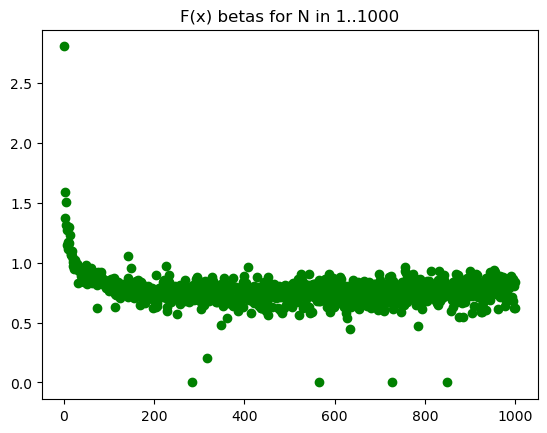

In [21]:
plt.scatter(list(range(1, len(betas)+1)), betas, color='green')
plt.title("F(x) betas for N in 1..1000")
plt.show()

### 1.3 Find optimal $alpha$ and $beta$ parameters

In [26]:
alpha_ = round(np.mean(alphas), 2)
beta_ = round(np.mean(betas), 2)

In [27]:
alpha_, beta_

(0.19, 0.77)

## PART 2: Find $R_N$ and $Q_N$ by fitting

In [28]:
# TODO: below depends on above
alpha = alpha_
beta = beta_

In [50]:
"""
Alternative approach:

    def scaling_func(qT, chi, kappa, gamma):
            q = qT[0]
            T = qT[1]
            x = q / np.power(T, kappa)
            return np.power(T, chi) * scale_function(x, alpha, beta) * gamma

    def fit_scaling_form(x, y):

        def _residuals(params, x, y):
            return y - scaling_func(x, *params)

        num_params = scaling_func.__code__.co_argcount - 1
        lower_bounds = [0] * num_params
        upper_bounds = [np.inf] * num_params
        bounds = (lower_bounds, upper_bounds)
        initial_guess = [0.5] * num_params
        result = least_squares(_residuals, initial_guess, args=(x, y),  bounds=bounds)
        return result.x
"""

'\nAlternative approach:\n\n    def scaling_func(qT, chi, kappa, gamma):\n            q = qT[0]\n            T = qT[1]\n            x = q / np.power(T, kappa)\n            return np.power(T, chi) * scale_function(x, alpha, beta) * gamma\n\n    def fit_scaling_form(x, y):\n\n        def _residuals(params, x, y):\n            return y - scaling_func(x, *params)\n\n        num_params = scaling_func.__code__.co_argcount - 1\n        lower_bounds = [0] * num_params\n        upper_bounds = [np.inf] * num_params\n        bounds = (lower_bounds, upper_bounds)\n        initial_guess = [0.5] * num_params\n        result = least_squares(_residuals, initial_guess, args=(x, y),  bounds=bounds)\n        return result.x\n'

In [30]:
def known_scale_function(x: float) -> float:
    """
    Define the sigmoidal function F(x) as mentioned in the paper.

    Parameters:
    - x (float): The value for which we are calculating the function.
    - alpha (float): Represents the small x growth power.
    - beta (float): Represents the large x growth power.

    Returns:
    - float: The result of the scale function for given x, alpha, and beta.
    """
    return x / (1 + abs(x) ** 1.2) ** (1.3 /1.2)


def aggregate_impact(Q: float, RN: float, QN: float) -> float:
    """
    Calculate the aggregate impact as described by equation 3 in the paper.

    Parameters:
    - Q (float): The aggregate volume.
    - RN (float): The N-dependent return scale.
    - QN (float): The N-dependent volume scale.
    - alpha (float): Represents the small x growth power.
    - beta (float): Represents the large x growth power.

    Returns:
    - float: The calculated aggregate impact.
    """
    return RN * known_scale_function(Q / QN)

# Example Usage:
# aggregate_impact(100, 1.2, 50, 1.2, 1.3)

In [31]:
def residuals_(params, x, y):
    return y - aggregate_impact(x, *params)

def fit_scaling_form_ls(x, y):

    num_params = aggregate_impact.__code__.co_argcount - 1
    # lower_bounds = [0] * num_params
    # upper_bounds = [np.inf] * num_params
    # bounds = (lower_bounds, upper_bounds)
    initial_guess = [np.mean(x)] * num_params
    result = least_squares(residuals_, initial_guess, args=(x, y)) # bounds=bounds
    return result.x

In [32]:
# x = tsla_agg_features[100]['vol_imbalance'].values
# y = tsla_agg_features[100]['R'].values
result = tsla_agg_features[100][['vol_imbalance', 'R']]
binned_result = bin_data_into_quantiles(result)
x = binned_result['vol_imbalance'].values
y = binned_result['R'].values

param = fit_scaling_form_ls(x, y)

/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/fitting.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_bin'] = binned_x


In [33]:
param

array([ 0.79786612, 37.64329989])

In [34]:

param

array([ 0.79786612, 37.64329989])

In [38]:
RN_values = []
QN_values = []

for lag in range(1, MAX_LAG):
    x = tsla_agg_features[lag]['vol_imbalance'].values
    y = tsla_agg_features[lag]['R'].values
    try:
        param = fit_scaling_form_ls(x, y)
        residuals = y - aggregate_impact(x, *param)
        r2, bic = compute_goodness_of_fit(residuals, y, param)

        RN_values.append(param[0])
        QN_values.append(param[1])
    except:
        print(f"Something went wrong for lag {lag}")

In [39]:
# Prepare data
from powerlaw_function import Fit
x = list(range(1, len(QN_values)+1))
xy_df = pd.DataFrame({
    'x_values': x,
    'y_values': QN_values
})

# Basic Usage
fit = Fit(xy_df, verbose= True)

Fitting pure_powerlaw function using Nonlinear Least-squares fitting method.


/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  adjusted_rsquared = 1 - (1 - rsquared) * (n - 1) / (n - p - 1)



For pure_powerlaw fitted using Nonlinear Least-squares;

Pre-fitting parameters:
xmin: 997.0

Fitting parameters:
param_names = ['C', 'alpha']
C = 275.26575313290465
alpha = 275.26575313290465

Goodness of fit to data:
BIC = 86.31221929682114
Adjusted R-squared = -inf


Using Linear fitting methods to approximation pure_powerlaw fit on Loglog scale.


/Users/ana_bugaenko/workspace/powerlaw_function/powerlaw_function/powerlaw_function.py:298: RuntimeWarning: overflow encountered in exp
  powerlaw_params = [np.exp(params[0]), -params[1]] # negative sign for alpha on linear scale, const
/Users/ana_bugaenko/workspace/powerlaw_function/util/supported_functions.py:7: RuntimeWarning: invalid value encountered in multiply
  return C * x ** -(alpha)



For pure_powerlaw fitted using OLS;

Pre-fitting parameters:
xmin: 997.0

Fitting parameters:
param_names = ['C', 'alpha']
C = inf
alpha = 128.173191282302

Goodness of fit to data:
BIC = nan
Adjusted R-squared = nan




/Users/ana_bugaenko/workspace/powerlaw_function/powerlaw_function/powerlaw_function.py:298: RuntimeWarning: overflow encountered in exp
  powerlaw_params = [np.exp(params[0]), -params[1]] # negative sign for alpha on linear scale, const
/Users/ana_bugaenko/workspace/powerlaw_function/util/supported_functions.py:7: RuntimeWarning: invalid value encountered in multiply
  return C * x ** -(alpha)



For pure_powerlaw fitted using RobustRegression;

Pre-fitting parameters:
xmin: 997.0

Fitting parameters:
param_names = ['C', 'alpha']
C = inf
alpha = 128.173191282302

Goodness of fit to data:
BIC = nan
Adjusted R-squared = nan



For pure_powerlaw fitted using GeneralisedRegression;

Pre-fitting parameters:
xmin: 997.0

Fitting parameters:
param_names = ['C', 'alpha']
C = inf
alpha = 128.173191282302

Goodness of fit to data:
BIC = nan
Adjusted R-squared = nan




/Users/ana_bugaenko/workspace/powerlaw_function/powerlaw_function/powerlaw_function.py:298: RuntimeWarning: overflow encountered in exp
  powerlaw_params = [np.exp(params[0]), -params[1]] # negative sign for alpha on linear scale, const
/Users/ana_bugaenko/workspace/powerlaw_function/util/supported_functions.py:7: RuntimeWarning: invalid value encountered in multiply
  return C * x ** -(alpha)


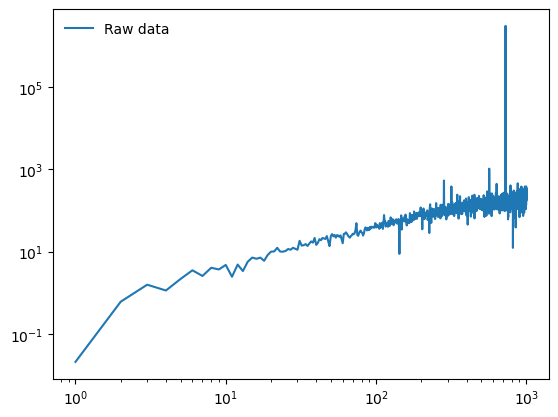

In [40]:
fit.plot_data()

In [155]:
result = tsla_agg_features[100][['vol_imbalance', 'R', 'T']]
binned_result = bin_data_into_quantiles(result)
x = binned_result['vol_imbalance'].values
y = binned_result['R'].values

In [157]:
param = fit_scaling_form_ls(x, y)
residuals = y - model_RN(x, *param)
r2, bic = compute_goodness_of_fit(residuals, y, param)

In [160]:
param

array([0.47473117, 0.35080587])

In [137]:
result = tsla_agg_features[100][['vol_imbalance', 'R', 'T']]
binned_result = bin_data_into_quantiles(result)
x = np.transpose(binned_result.iloc[:, :2].to_numpy())
y = binned_result.iloc[:, 2].to_numpy()

In [143]:
param = fit_scaling_form(x, y)
residuals = y - scaling_func(x, *param)
r2, bic = compute_goodness_of_fit(residuals, y, param)

In [144]:
r2

0.815213724371021

In [145]:
bic

-127.98039265565146

In [146]:
param

array([1.39780203e-01, 1.52386005e-10, 4.10922035e-01])

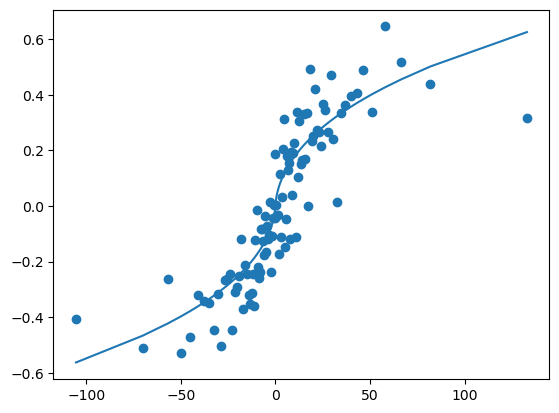

In [153]:
plt.scatter(x[0], y)
plt.plot(x[0], scaling_func(x, *param))

In [180]:
# Generate data spanning several orders of magnitude
data = np.random.lognormal(mean=1, sigma=1.5, size=10000)

# Logarithmic binning
bin_edges = np.logspace(np.log10(min(data)), np.log10(max(data)), num=50) # Create 50 logarithmically spaced bins

plt.hist(data, bins=bin_edges, edgecolor='k')
plt.title('Logarithmic Binning Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xscale('log') # To better visualize on a log scale
plt.show()